## UNZIPPING DATA

In [ ]:
!tar -xvzf "lfw.tgz"

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import random as rand
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import os
import cv2
from math import log10, sqrt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.utils import to_categorical
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import mtcnn
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
from sklearn.datasets import fetch_lfw_people
from numpy.linalg import norm

**LOADING MTCNN MODEL**

In [ ]:
detector = mtcnn.MTCNN()

LOADING DATA AND EXTRACTING FACE FROM THE PICTURE

In [ ]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/lfw/'):
    if len(filenames) >= 40:
        print(dirname.split("/")[-1])
        pass
    else:
        continue
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        Result_Training.append(dirname.split("/")[-1])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = detector.detect_faces(img)
        x1, y1, h, w = result[0]["box"]
        x2, y2 = x1 + w, y1 + h
        face = img[y1:y2, x1:x2]
        print("Face Dimentions: ", face.shape)
        img = cv2.resize(face, (128, 128))
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
Face Dimentions:  (105, 136, 3)
1/1 [==============================] - 0s 35ms/step
Face Dimentions:  (94, 132, 3)
1/1 [==============================] - 0s 30ms/step
Face Dimentions:  (101, 140, 3)
1/1 [==============================] - 0s 29ms/step
Face Dimentions:  (97, 134, 3)
1/1 [==============================] - 0s 25ms/step
Face Dimentions:  (95, 133, 3)
1/1 [==============================] - 0s 26ms/step
Face Dimentions:  (90, 121, 3)
1/1 [==============================] - 0s 29ms/step
Face Dimentions:  (101, 143, 3)
1/1 [==============================] - 0s 27ms/step
Face Dimentions:  (87, 115, 3)
1/1 [==============================] - 0s 39ms/step
Face Dimentions:  (92, 129, 3)
1/1 [==============================] - 0s 43ms/step
Face Dimentions:  (90, 127, 3)
1/1 [==============================] - 0s 46ms/step
Face Dimentions:  (87, 122, 3)
1/1 [============================

((1867, 128, 128, 3), (1867,))

# DATA PREPROCESSING

In [ ]:
Result = Result_Training
np.array(Result).shape

(1867,)

In [ ]:
lb = LabelEncoder()
Result = lb.fit_transform(Result)

In [ ]:
Temp = []
for i in Result:
    temp = []
    temp.append(i)
    Temp.append(temp)
output_matrix = to_categorical(Temp)
total = output_matrix.shape[1]
output_matrix.shape

(1867, 19)

FUCTIONS FOR PSNR AND SSIM

In [ ]:
def cos(original, compressed):
  cos_sim = np.dot(original.reshape(-1), compressed.reshape(-1)) / (norm(original.reshape(-1)) * norm(compressed.reshape(-1)))
  return round(cos_sim, 2)

In [ ]:
def mag(original, compressed):
  mag_sim = min(norm(original.reshape(-1)) / norm(compressed.reshape(-1)), norm(compressed.reshape(-1)) / norm(original.reshape(-1)))
  return round(mag_sim, 2)

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                   # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return round(psnr, 2)

In [ ]:
def SSIMS(original, compressed):
  return round(ssim(original, compressed, multichannel=True), 2)

In [ ]:
def Print_ALL(original, compressed):
  print("PSRN: ", PSNR(original, compressed))
  print("SSIM: ", SSIMS(original, compressed))
  print("COS: ", cos(original, compressed))
  print("MAG: ", mag(original, compressed))

In [ ]:
def Print_data(y_real, y_pre):
    cm = confusion_matrix(y_real, y_pre)
    for c in range(19):
        try:
            tp = cm[c,c]
            fp = sum(cm[:,c]) - cm[c,c]
            fn = sum(cm[c,:]) - cm[c,c]
            tn = sum(np.delete(sum(cm)-cm[c,:],c))

            if tp+fp == 0:
                precision = 1
            else:
                precision = tp/(tp+fp)
            if (tp+fn) == 0:
                recall = 1
            else:
                recall = tp/(tp+fn)
            if (tn+fp) == 0:
                specificity = 1
            else:
                specificity = tn/(tn+fp)
            if (precision+recall) == 0:
                f1_score = 1
            else:
                f1_score = 2*((precision*recall)/(precision+recall))

            #print(f"for class {c}: acc {accuracy}, recall {recall},\
            #      precision {precision}, f1 {f1_score}")
            print("for class {}: recall {}, specificity {}\
                    precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))
        except:
            continue

DOWNSAMPLING CODE FOR IMAGES TO CONVERT THEM TO LR

In [ ]:
def down_sampling(ar, fact):
    res = ar[::fact, ::fact]
    return res

In [ ]:
LR = []
for i in tqdm(range(len(Training)),desc="CONVERTING"):
  LR.append(down_sampling(Training[i], 4))
np.array(LR).shape

CONVERTING: 100%|██████████| 1867/1867 [00:00<00:00, 195329.65it/s]


(1867, 32, 32, 3)

TRUTH GROUND IMAGES AND LR IMAGES

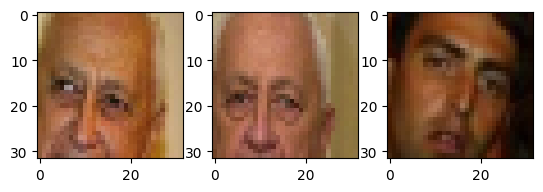

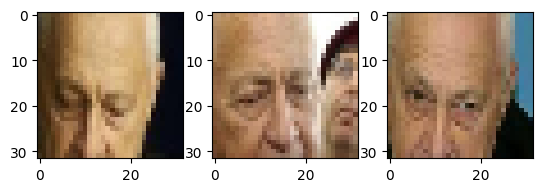

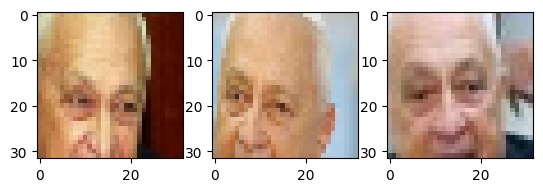

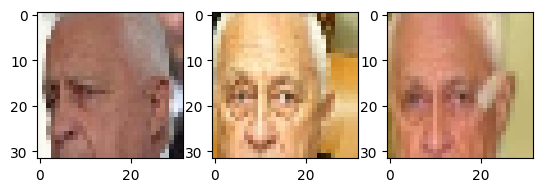

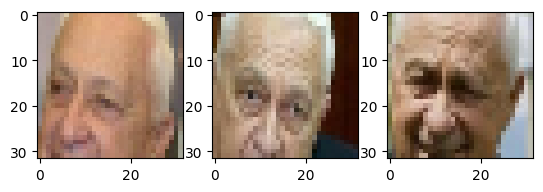

In [ ]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(LR[i])
    plt.sca(axarr[1]); 
    plt.imshow(LR[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(LR[i+2])
    plt.show()

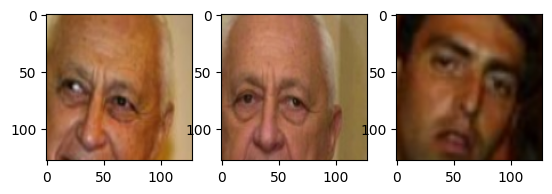

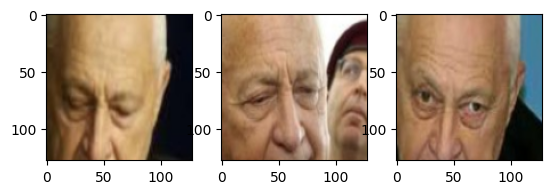

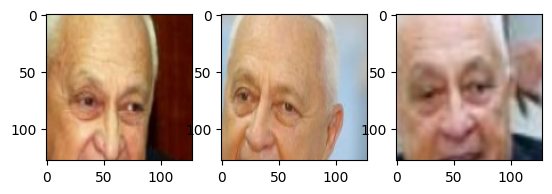

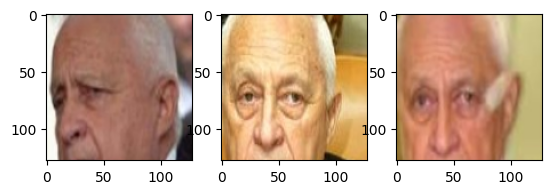

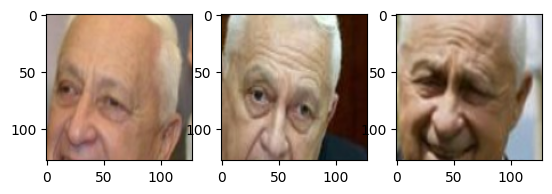

In [ ]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Training[i])
    plt.sca(axarr[1]); 
    plt.imshow(Training[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Training[i+2])
    plt.show()

# LAPSRN

In [ ]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/LapSRN_x4.pb')
super_res.setModel('lapsrn',4)

In [ ]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 1867/1867 [01:37<00:00, 19.21it/s]


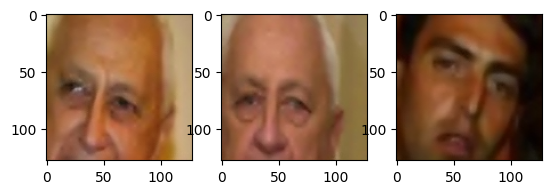

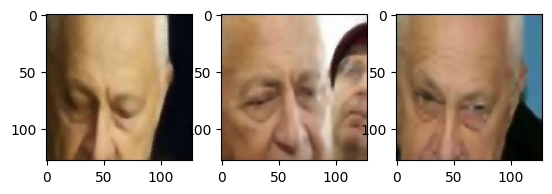

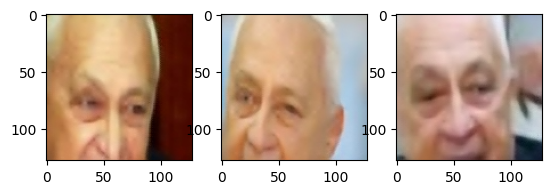

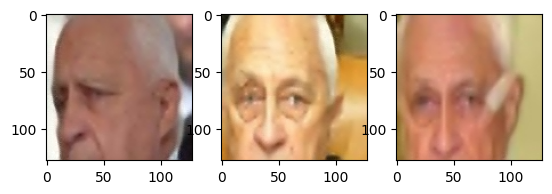

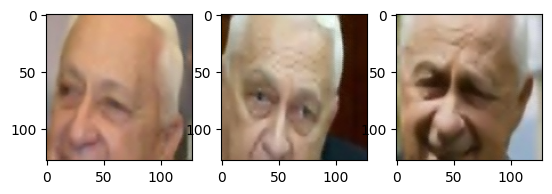

In [ ]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULT OF UPSAMPLING**

In [ ]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.04


<ipython-input-32-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94
COS:  0.0
MAG:  1.0


**TAINING AND TESTING DATA**

In [ ]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Training), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape 

((1680, 128, 128, 3), (187, 128, 128, 3))

# RESNET50 MODEL

In [ ]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_15 (Dense)            (None, 19)                38931     
                                                                 
Total params: 27,822,995
Trainable params: 4,235,283
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
53/53 [==============================] - 9s 45ms/step - loss: 2.7409 - accuracy: 0.4702 - precision: 0.6203 - recall: 0.3208
Epoch 2/10
53/53 [==============================] - 2s 36ms/step - loss: 0.6280 - accuracy: 0.8143 - precision: 0.9039 - recall: 0.7113
Epoch 3/10
53/53 [==============================] - 2s 37ms/step - loss: 0.3125 - accuracy: 0.9173 - precision: 0.9498 - recall: 0.8673
Epoch 4/10
53/53 [==============================] - 2s 35ms/step - loss: 0.1705 - accuracy: 0.9601 - precision: 0.9757 - recall: 0.9333
Epoch 5/10
53/53 [==============================] - 2s 35ms/step - loss: 0.1056 - accuracy: 0.9792 - precision: 0.9896 - recall: 0.9631
Epoch 6/10
53/53 [==============================] - 2s 35ms/step - loss: 0.0525 - accuracy: 0.9940 - precision: 0.9976 - recall: 0.9905
Epoch 7/10
53/53 [==============================] - 2s 35ms/step - loss: 0.0294 - accuracy: 0.9988 - precision: 1.0000 - recall: 0.9970
Epoch 8/10
53/53 [==============================

# IMPORTANT PLOTS

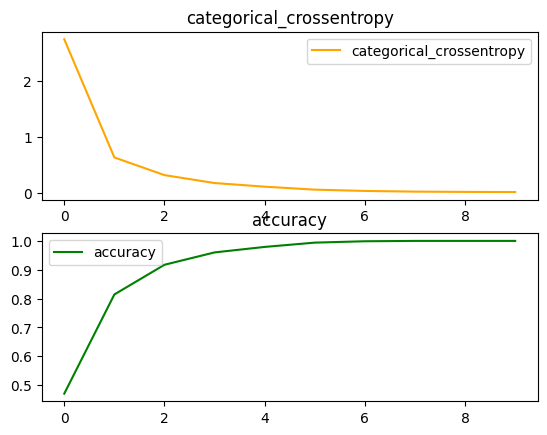

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

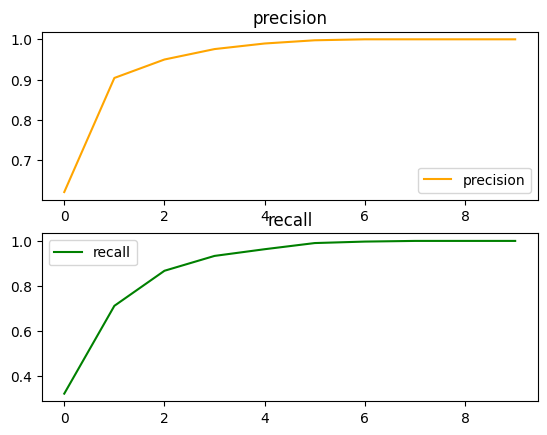

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

# ANSWERS

In [ ]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

6/6 [==============================] - 2s 170ms/step - loss: 0.6272 - accuracy: 0.8610 - precision: 0.8876 - recall: 0.8449
ACCURACY:  0.86
LOSS:  0.63
Precision:  0.89
Recall:  0.84


In [ ]:
pre = resnet_model.predict(X_test)

6/6 [==============================] - 1s 30ms/step


In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

<Axes: >

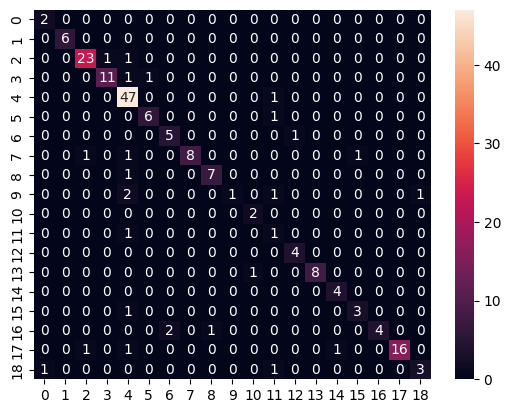

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 0.9946            precision 0.6667, f1 0.8
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 0.92, specificity 0.9877            precision 0.92, f1 0.92
for class 3: recall 0.8462, specificity 0.9943            precision 0.9167, f1 0.88
for class 4: recall 0.9792, specificity 0.9353            precision 0.8393, f1 0.9038
for class 5: recall 0.8571, specificity 0.9944            precision 0.8571, f1 0.8571
for class 6: recall 0.8333, specificity 0.989            precision 0.7143, f1 0.7692
for class 7: recall 0.7273, specificity 1.0            precision 1.0, f1 0.8421
for class 8: recall 0.875, specificity 0.9944            precision 0.875, f1 0.875
for class 9: recall 0.2, specificity 1.0            precision 1.0, f1 0.3333
for class 10: recall 1.0, specificity 0.9946            precision 0.6667, f1 0.8
for class 11: recall 0.5, specificity 0.9784            precision 0.2, f1 0.2857
for class 12: recall 1.

IndexError: ignored

# MOBILENETv2

In [ ]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [ ]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=20)

**Graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_1"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_1"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answers**

In [ ]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = mobile_model.predict(X_test)

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

# EDSR MODEL

In [ ]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/EDSR_x4.pb')
super_res.setModel('edsr',4)

In [ ]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

In [ ]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**Comapring The SR result**

In [ ]:
Print_ALL(np.array(Training), np.array(Temp_Train))

**TESTING AND TRAINING**

In [ ]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Training), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape 

# RESNET50 MODEL

In [ ]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [ ]:
resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

**graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_2"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_2"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answer**

In [ ]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = resnet_model.predict(X_test)

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

# MOBILENETv2

In [ ]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [ ]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=20)

**Graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_3"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_3"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**ANSWERS**

In [ ]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = mobile_model.predict(X_test)

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

# BICUBIC MODEL

In [ ]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = cv2.resize(LR[i], (128, 128), interpolation=cv2.INTER_CUBIC)
  Temp_Train.append(img)

In [ ]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULTS**

In [ ]:
Print_ALL(np.array(Training), np.array(Temp_Train))

In [ ]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Training), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape 

# RESNET50 MODEL

In [ ]:
resnet_model = Sequential()
pretrained_mRESULTSodel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [ ]:
resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

**Graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_4"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_4"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answers**

In [ ]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = resnet_model.predict(X_test)

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

# MOBILENETv2

In [ ]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [ ]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=20)

**graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_5"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_5"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answers**

In [ ]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = mobile_model.predict(X_test)

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

# Original DATASET

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Training), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape

In [ ]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_6"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_6"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [ ]:
answer = resnet_model.evaluate(np.array(X_test), Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = resnet_model.predict(np.array(X_test))

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

In [ ]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [ ]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(np.array(X_train), Y_train, batch_size=32, epochs=20)

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_7"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_7"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [ ]:
answer = mobile_model.evaluate(np.array(X_test), Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = mobile_model.predict(np.array(X_test))

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

# Low Resolution DATASET

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(LR), np.array(output_matrix), shuffle=True, random_state=128, train_size=.9)
X_train.shape, X_test.shape

In [ ]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32, 32, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10)

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_8"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_8"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [ ]:
answer = resnet_model.evaluate(np.array(X_test), Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = resnet_model.predict(np.array(X_test))

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)

In [ ]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(32, 32, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [ ]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(np.array(X_train), Y_train, batch_size=32, epochs=20)

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_9"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_9"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [ ]:
answer = mobile_model.evaluate(np.array(X_test), Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

In [ ]:
pre = mobile_model.predict(np.array(X_test))

In [ ]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

In [ ]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [ ]:
Print_data(y_real, y_pre)